# How do lesions to NCM affect performance in this memory task?

We look at (1) overall odds ratio during full test days (Song 8v8 and DC 6v6) before and after lesion, and (2) the effect of the lesion on learning curves.

In [116]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "..", "code"))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from utils import Colors
from load_data import (
    load_behavioral_data,
    load_lesion_data
)
from stats import (
    fisher_exact,
    get_odds_ratio_matrix,
    jackknife,
    linreg,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
trial_data = load_behavioral_data()

In [3]:
lesion_data = load_lesion_data()

In [85]:
lesion_data = lesion_data.drop(index=6).reindex()

## 1. Show overall odds ratios as a function of lesion size

### First, summarize overall performance as an odds ratio

This code taken nearly verbatim from https://github.com/theunissenlab/zebra-finch-memory

In [86]:
performance_df_rows = []
for subject in lesion_data["Subject"]:
    subject_df = trial_data[
        (trial_data["Subject"] == subject)
    ]
    
    for ctx, condition in [
                ("SovsSo_8v8_d2", "PrelesionSet1"),
                ("DCvsDC_6v6_d2", "PrelesionSet1"),
                ("SovsSo_8v8_d2", "PostlesionSet1"),
                ("DCvsDC_6v6_d2", "PostlesionSet1"),
            ]:
        ctx_df = subject_df[(subject_df["Test Context"] == ctx) & (subject_df["Ladder Group"] == condition)]

        rewarded_set = ctx_df[ctx_df["Stimulus Class"] == "Rewarded"]
        nonrewarded_set = ctx_df[ctx_df["Stimulus Class"] == "Nonrewarded"]

        table = get_odds_ratio_matrix(nonrewarded_set, rewarded_set, "Interrupt")
        odds, interval95, p_value = fisher_exact(table, side="greater")
        se_logor = np.sqrt(
            np.sum(1 / table)
        )

        performance_df_rows.append(
            [
                subject, ctx, condition, odds, interval95[0], interval95[1], np.log(odds), se_logor, p_value, 
            ]
        )

performance_df = pd.DataFrame(
    performance_df_rows,
    columns=["Subject", "Test Context", "Ladder Group", "Odds Ratio", "95 CI Lower", "95 CI Upper", "LogOR", "SE(LogOR)", "p-value"]
)

In [87]:
lesions_by_performance_df = lesion_data.merge(performance_df, on="Subject")

In [88]:
lesions_by_performance_df.head(10)

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected,Test Context,Ladder Group,Odds Ratio,95 CI Lower,95 CI Upper,LogOR,SE(LogOR),p-value
0,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,SovsSo_8v8_d2,PrelesionSet1,8.372638,5.463430,inf,2.124969,0.262190,6.881266e-22
1,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,DCvsDC_6v6_d2,PrelesionSet1,9.013190,6.519035,inf,2.198689,0.197821,1.052477e-34
2,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,SovsSo_8v8_d2,PostlesionSet1,2.474424,1.873942,inf,0.906008,0.169541,1.377995e-08
3,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False,DCvsDC_6v6_d2,PostlesionSet1,2.979033,2.274227,inf,1.091599,0.164532,5.639628e-12
4,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False,SovsSo_8v8_d2,PrelesionSet1,18.913151,12.587575,inf,2.939857,0.249287,4.851571e-42
5,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False,DCvsDC_6v6_d2,PrelesionSet1,12.717170,9.702200,inf,2.542953,0.164922,8.018391e-63
6,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False,SovsSo_8v8_d2,PostlesionSet1,22.538041,14.732104,inf,3.115205,0.260764,6.334177e-46
7,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False,DCvsDC_6v6_d2,PostlesionSet1,13.138754,8.017707,inf,2.575566,0.304032,2.192383e-23
8,BlaGre1349M,2019-06-26,202323775,315227225,517551000,False,SovsSo_8v8_d2,PrelesionSet1,89.984565,56.409432,inf,4.499638,0.288248,8.023539e-131
9,BlaGre1349M,2019-06-26,202323775,315227225,517551000,False,DCvsDC_6v6_d2,PrelesionSet1,60.825324,40.050942,inf,4.108006,0.256065,1.492662e-91


### Summarize effect of lesion as ratio between post- and pre-lesion odds ratios

In [89]:
# Collapse the rows belonging to the same test context by subject

results = []
for (subject, ctx), subj_df in lesions_by_performance_df.groupby(["Subject", "Test Context"]):
    prelesion_OR = subj_df[subj_df["Ladder Group"] == "PrelesionSet1"].iloc[0]["Odds Ratio"]
    postlesion_OR = subj_df[subj_df["Ladder Group"] == "PostlesionSet1"].iloc[0]["Odds Ratio"]
    
    results.append({
        "call_type": "So" if ctx == "SovsSo_8v8_d2" else "DC",
        "OR_ratio": postlesion_OR / prelesion_OR,
        "Lesion": subj_df.iloc[0]["Total_Lesion_Size"]
    })
results = pd.DataFrame(results)

In [90]:
def lesion_analysis(df, ax=None):
    if ax is None:
        ax = plt.gca()

    # Do a linear regression
    popt, pcov, lin, r_squared, r_adj, sigma_ab = linreg(df["Lesion"], df["OR_ratio"])
    cc, _ = pearsonr(df["Lesion"], df["OR_ratio"])
    
    ax.scatter(
        df["Lesion"],
        df["OR_ratio"],
        color="Black",
        s=80
    )
    
    # Plot best fit line
    xarr = np.linspace(np.min(df["Lesion"]), np.max(df["Lesion"]), 3)
    ax.plot(xarr, lin(xarr), color="Grey", linestyle="--")
    
    ax.set_ylabel("Odds Ratio\nPost/Pre", fontsize=20)
    ax.set_xlabel("Lesion Size ($\mu m^3$)", fontsize=20)
    
    return r_adj, cc

### Small effect of NCM lesion size on Song performance

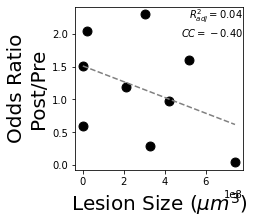

In [91]:
fig = plt.figure(figsize=(3, 3))
r_adj, cc = lesion_analysis(results.query("call_type == 'So'"))
plt.text(
    1,
    1,
    "$R^2_{{adj}} = {:.2f}$\n$CC = {:.2f}$".format(r_adj, cc), 
    verticalalignment="top", 
    horizontalalignment="right",
    transform=plt.gca().transAxes
)
plt.show()
plt.close(fig)

### Strong effect of NCM lesion size on DC performance

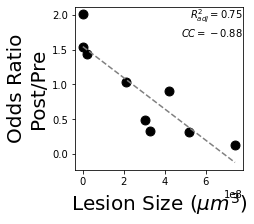

In [92]:
fig = plt.figure(figsize=(3, 3))
r_adj, cc = lesion_analysis(results.query("call_type == 'DC'"))
plt.text(
    1,
    1,
    "$R^2_{{adj}} = {:.2f}$\n$CC = {:.2f}$".format(r_adj, cc), 
    verticalalignment="top", 
    horizontalalignment="right",
    transform=plt.gca().transAxes
)
plt.show()
plt.close(fig)

## 2. Show if lesions have an effect on learning curves

Again, learning curve code based on https://github.com/theunissenlab/zebra-finch-memory

Learning curves plotted as an odds ratio between interrupting nonrewarded and rewarded vocalizers are generated as an average across subjects. However, showing this per-subject is a bit difficult.

In [111]:
def inject_relative_informative_trials(df):
    """Takes a dataframe with a subset of trials and injects a column of "Relative Informative Trials Seen"
    which indicates the number of informative trials seen by a subject for a given vocalizer in the
    selected range
    """
    df = df.copy()
    df["Relative Informative Trials Seen"] = df["Informative Trials Seen"]
    for (subj, vocalizer, call_type), subdf in df.groupby(["Subject", "Stimulus Vocalizer", "Stimulus Call Type"]):
        df.loc[
            subdf.index,
            "Relative Informative Trials Seen"
        ] -= subdf.iloc[0]["Informative Trials Seen"]
    
    return df

def generate_informative_trial_dataframe(df, informative_trials):
    """Generate a dataframe with interruption data per bin per subject per stimulus
    from the selected trials
    """
    # The "Informative Trials Seen" column counts informative trials seen for a given stim across
    # all sessions run for a subject. The given dataframe may only include trials from a selected
    # epoch which may not include the first sessions. So we create a new "Relative Informative Trials Seen"
    # column that shows number of informative trials seen relative to the start of the requested range.
    df = inject_relative_informative_trials(df)
    output_rows = []
    for bin_idx in informative_trials:
        bin_df = df[df["Relative Informative Trials Seen"] == bin_idx]
        for (subject, subject_sex, vocalizer, call_type, rewarded), stim_df in bin_df.groupby([
                    "Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type", "Stimulus Class"
                ]):
            output_rows.append([
                subject,
                subject_sex,
                vocalizer,
                call_type,
                rewarded,
                bin_idx,
                len(stim_df),
                np.mean(stim_df["Interrupt"])  # This should be just 1 / len(stim_df)
            ])
            
    return pd.DataFrame(output_rows, columns=["Subject", "Subject Sex", "Stimulus Vocalizer", "Stimulus Call Type",
            "Stimulus Class", "Relative Informative Trials Seen", "Bin Size", "p(interrupt)"])

def process_learning_curve_data(df, informative_trials):
    """
    Collect probability of interruption across subjects in each informative trial bin
    
    df: pandas DataFrame filtered down to the trials of interest
    informative_trials: numpy array of integers for the informative trial bins requested (e.g. np.arange(10))
    """
    inform_df = generate_informative_trial_dataframe(df, informative_trials)
    
    binned = inform_df.groupby([
        "Relative Informative Trials Seen", "Stimulus Class"
    ])
    
    output_rows = []
    for (bin_idx, rewarded), subdf in binned:
        mean, sem = jackknife(subdf["p(interrupt)"], np.mean)
        output_rows.append([bin_idx, rewarded, mean, sem])
    output = pd.DataFrame(output_rows, columns=["Informative Trials", "Stimulus Class", "p(interrupt)", "SEM"])
    output = output.sort_values(["Informative Trials", "Stimulus Class"])

    return output


In [112]:
valid_subjects = lesion_data["Subject"]

In [152]:
song_prelesion = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Stimulus Call Type"] == "SO")
]
song_postlesion = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet1") &
    (trial_data["Stimulus Call Type"] == "SO")
]

dc_prelesion = trial_data[
    (trial_data["Ladder Group"] == "PrelesionSet1") &
    (trial_data["Stimulus Call Type"] == "DC")
]
dc_postlesion = trial_data[
    (trial_data["Ladder Group"] == "PostlesionSet1") &
    (trial_data["Stimulus Call Type"] == "DC")
]

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
0,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False


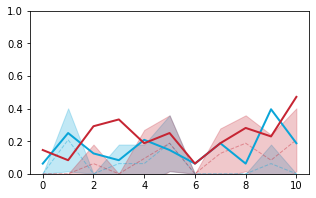

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
1,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False


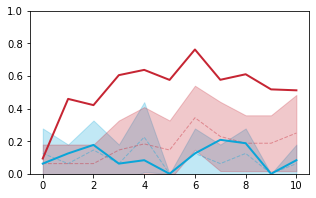

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
2,BlaGre1349M,2019-06-26,202323775,315227225,517551000,False


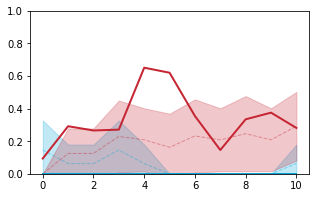

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
3,BluYel2571F,2019-05-02,0,0,0,False


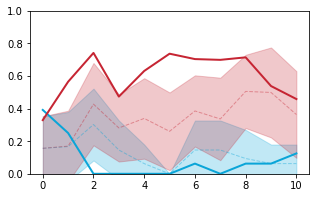

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
4,GreBla3404M,2019-05-03,342048200,80934775,422982975,False


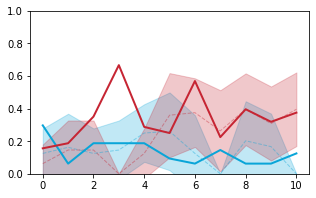

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
5,GreBlu5039F,2019-05-02,303389425,0,303389425,True


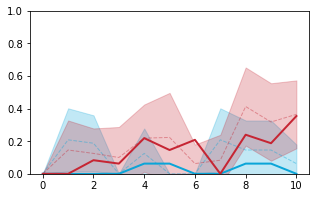

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
7,XXXOra0037F,2019-09-06,501660575,241844175,743504750,False


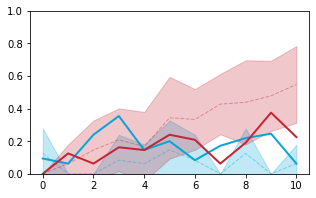

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
8,WhiWhi2526M,2019-09-06,3371000,15746500,19117500,False


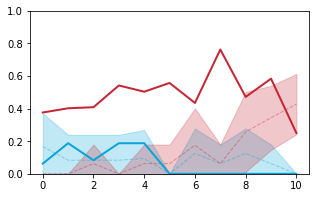

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
9,YelPur7906M,2019-09-06,0,0,0,False


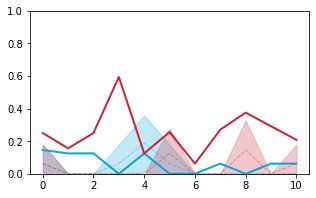

In [153]:
for subject in valid_subjects:
    display(lesion_data[lesion_data["Subject"] == subject])
    prelesion_curve_data = process_learning_curve_data(
        song_prelesion[song_prelesion["Subject"] == subject],
        np.arange(11)
    )
    fig = plt.figure(figsize=(5, 3))
    for reward in ["Rewarded", "Nonrewarded"]:
        rew_df = prelesion_curve_data[prelesion_curve_data["Stimulus Class"] == reward]
        plt.plot(
            rew_df["Informative Trials"],
            rew_df["p(interrupt)"],
            linewidth=1,
            linestyle="--",
            color=Colors.base_rewarded if reward == "Rewarded" else Colors.base_nonrewarded,
            alpha=0.4
        )

        plt.fill_between(
            rew_df["Informative Trials"],
            rew_df["p(interrupt)"] - 2 * rew_df["SEM"],
            rew_df["p(interrupt)"] + 2 * rew_df["SEM"],
            color=Colors.base_rewarded if reward == "Rewarded" else Colors.base_nonrewarded,
            alpha=0.25
        )

    postlesion_curve_data = process_learning_curve_data(
        song_postlesion[song_postlesion["Subject"] == subject],
        np.arange(11)
    )
    
    for reward in ["Rewarded", "Nonrewarded"]:
        rew_df = postlesion_curve_data[postlesion_curve_data["Stimulus Class"] == reward]
        plt.plot(
            rew_df["Informative Trials"],
            rew_df["p(interrupt)"],
            linewidth=2,
            color=Colors.base_rewarded if reward == "Rewarded" else Colors.base_nonrewarded
        )
    
        
    plt.ylim(0, 1)
    plt.show()


,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
0,GraWhi4040F,2019-06-25,76082075,253347900,329429975,False


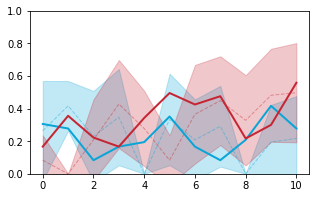

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
1,XXXHpi0038M,2019-06-26,147836250,63015600,210851850,False


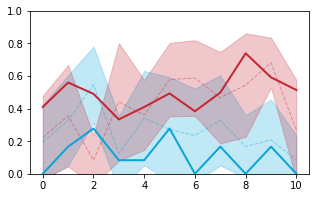

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
2,BlaGre1349M,2019-06-26,202323775,315227225,517551000,False


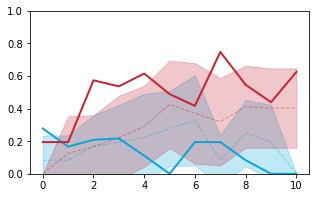

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
3,BluYel2571F,2019-05-02,0,0,0,False


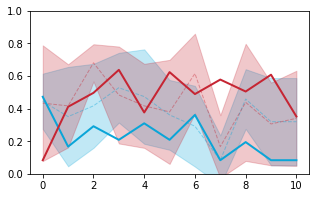

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
4,GreBla3404M,2019-05-03,342048200,80934775,422982975,False


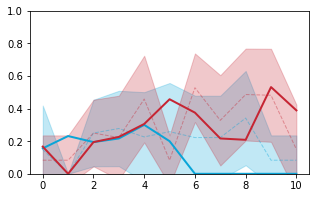

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
5,GreBlu5039F,2019-05-02,303389425,0,303389425,True


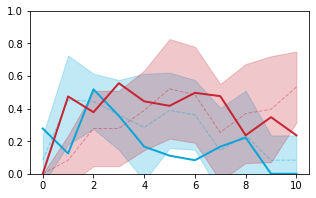

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
7,XXXOra0037F,2019-09-06,501660575,241844175,743504750,False


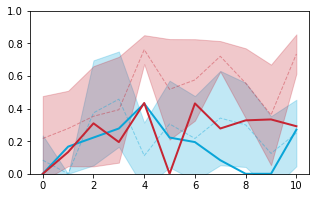

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
8,WhiWhi2526M,2019-09-06,3371000,15746500,19117500,False


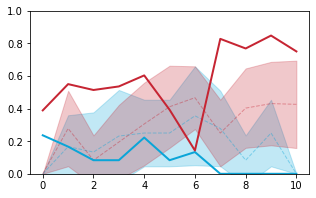

,Subject,Date_Lesioned,LH_Lesion_Size,RH_Lesion_Size,Total_Lesion_Size,Hippocampus_Affected
9,YelPur7906M,2019-09-06,0,0,0,False


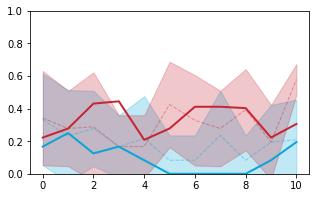

In [154]:
for subject in valid_subjects:
    display(lesion_data[lesion_data["Subject"] == subject])
    prelesion_curve_data = process_learning_curve_data(
        dc_prelesion[dc_prelesion["Subject"] == subject],
        np.arange(11)
    )
    fig = plt.figure(figsize=(5, 3))
    for reward in ["Rewarded", "Nonrewarded"]:
        rew_df = prelesion_curve_data[prelesion_curve_data["Stimulus Class"] == reward]
        plt.plot(
            rew_df["Informative Trials"],
            rew_df["p(interrupt)"],
            linewidth=1,
            linestyle="--",
            color=Colors.base_rewarded if reward == "Rewarded" else Colors.base_nonrewarded,
            alpha=0.4
        )

        plt.fill_between(
            rew_df["Informative Trials"],
            rew_df["p(interrupt)"] - 2 * rew_df["SEM"],
            rew_df["p(interrupt)"] + 2 * rew_df["SEM"],
            color=Colors.base_rewarded if reward == "Rewarded" else Colors.base_nonrewarded,
            alpha=0.25
        )

    postlesion_curve_data = process_learning_curve_data(
        dc_postlesion[dc_postlesion["Subject"] == subject],
        np.arange(11)
    )
    
    for reward in ["Rewarded", "Nonrewarded"]:
        rew_df = postlesion_curve_data[postlesion_curve_data["Stimulus Class"] == reward]
        plt.plot(
            rew_df["Informative Trials"],
            rew_df["p(interrupt)"],
            linewidth=2,
            color=Colors.base_rewarded if reward == "Rewarded" else Colors.base_nonrewarded
        )
    
        
    plt.ylim(0, 1)
    plt.show()
